# Regresion

## Preparación de ambiente

### Carga de librerías

In [1]:
# Data Wrangling
import os
import numpy as np
import pandas as pd
from datetime import date, datetime
#from pandarallel import pandarallel
from dateutil.relativedelta import relativedelta as rd
from funpymodeling.exploratory import status

# Preprocesamiento
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Modelado
import keras
import sklearn
from keras import metrics, Input
from keras.models import Sequential, Model
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.feature_selection import VarianceThreshold
from keras.layers import Embedding, Dense, Flatten, Dropout
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split

# Visualización
import cufflinks as cf
from sklearn import set_config
import matplotlib.pyplot as plt

# Configuración de ambiente
cf.go_offline()
set_config(display='diagram')
pd.set_option('display.max_columns', 50)
#pandarallel.initialize(progress_bar=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Funciones relevantes

In [2]:
def semiverseno(lat1, lon1, lat2, lon2):
    """
    This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine
    formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    c = 2 ⋅ atan2( √a, √(1−a) )
    d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    try:
        R = 6371.0088 # Radio de la tierra
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
        c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
        d = R * c
        return float(round(d,4))
    except:
        return 0.0

In [3]:
def make_embedding(X, X_v, feature, target, embedding_size=3):
    print(f"Creating embedding for {feature}\n")
    le = LabelEncoder()
    X_feat = le.fit_transform(X[feature])
    model = Sequential()
    model.add(Embedding(input_dim = len(le.classes_), output_dim = embedding_size, input_length = 1, name="embedding"))
    model.add(Flatten())
    model.add(Dense(20, activation="relu"))
    model.add(Dense(10, activation="tanh"))
    model.add(Dense(1, activation="softmax"))
    kmetrics = [
        metrics.Accuracy(name="accuracy"),
        metrics.AUC(name="roc")
    ]   
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=[kmetrics])
    model.fit(x = X_feat, y=X[target].to_numpy() , epochs = 25, batch_size = 6000)
    layer = model.get_layer('embedding')
    output_embeddings = layer.get_weights()
    X_emb = pd.DataFrame(output_embeddings[0], columns=[f"{feature}_embedding_{x}" for x in range(embedding_size)])
    X_emb.reset_index(drop=False, inplace=True)
    X_emb[feature] = X_emb["index"].map(lambda x: le.inverse_transform([x])[0])
    X = X.merge(X_emb, on = feature, how="inner").drop(columns=[feature, "index"])
    X_v = X_v.merge(X_emb, on = feature, how="left").drop(columns=[feature, "index"])
    return X, X_v, X_emb

In [4]:
def make_autoencoder(X_train, encoding_dim=16, batch_size=500, epochs=20):
    kmetrics = [
        metrics.RootMeanSquaredError(name='rms'),
        metrics.MeanAbsoluteError(name='mae')
    ]   
    len_input_output = X_train.shape[-1]
    input_ = Input(shape=(len_input_output,))
    encoded = Dense(units=encoding_dim*2, activation="relu")(input_)
    bottleneck = Dense(units=encoding_dim, 
                       activation="relu")(encoded)
    decoded = Dense(units=encoding_dim*2, 
                    activation="relu")(bottleneck)
    output = Dense(units=len_input_output, 
                    activation="linear")(decoded)
    autoencoder = Model(inputs=input_, outputs=output)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error',
                        metrics=[kmetrics])
    autoencoder.fit(X_train, X_train,
                    batch_size=batch_size,
                    epochs=epochs)
    encoder = Model(inputs=input_, outputs=bottleneck)
    return autoencoder, encoder

In [5]:
def regression_metrics(X,y,pipe,model):
    pipe = Pipeline(pipe.steps + [("model", model)])
    ls_scores_r2 = cross_val_score(estimator=pipe, X=X, y=y, scoring="r2", n_jobs=-1, cv=4)
    print(f"R2 media: {np.mean(ls_scores_r2):,.2f}, desviación estándar: {np.std(ls_scores_r2):,.2f}")
    return np.mean(ls_scores_r2)

In [6]:
def hyperparam_logistic(X, y, pipe, model, param_grid):
    pipe = Pipeline(pipe.steps + [("model", model)])
    hp = RandomizedSearchCV(cv=4, 
                            param_distributions=param_grid,
                            n_iter=5,
                            scoring="r2", 
                            verbose=10,
                            error_score=-1000, 
                            estimator=pipe, 
                            n_jobs=-1,
                            random_state=0)
    hp.fit(X=X, y = y)
    print(f"R2: {hp.best_score_:,.2f}")
    return hp

## Data Wrangling

### Lectura de datos

In [7]:
df_t = pd.read_csv("./train_PAY_AMT1.csv",sep='|')
df_v = pd.read_csv("./val_PAY_AMT1.csv",sep='|')

In [8]:
print(df_t.shape,df_v.shape)
df_t.head()

(11250, 23) (3750, 22)


,CUSTOMER_ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2770,130000.0000,2,3,2,32,0,0,0,0,2,119312.0000,116259.0000,103438.0000,49319.0000,91191.0000,82168.0000,20021.0000,40354.0000,20000.0000,43608.0000,103.0000,10000.0000
1,21621,10000.0000,2,2,2,22,-2,-2,-2,-2,-2,0.0000,0.0000,0.0000,-400.0000,0.0000,0.0000,0.0000,0.0000,0.0000,400.0000,0.0000,0.0000
2,23530,360000.0000,2,1,1,46,0,-1,0,0,0,58389.0000,42094.0000,10594.0000,31532.0000,46342.0000,56571.0000,20000.0000,10600.0000,30000.0000,20000.0000,15000.0000,10000.0000
3,27980,80000.0000,2,2,2,60,-2,-2,-2,-2,-2,577.0000,494.0000,438.0000,387.0000,246.0000,939.0000,500.0000,438.0000,387.0000,246.0000,939.0000,350.0000
4,20014,230000.0000,2,2,2,28,-1,-1,-2,-1,-1,875.0000,375.0000,-250.0000,-125.0000,609.0000,362.0000,1000.0000,0.0000,0.0000,4000.0000,3000.0000,9000.0000


In [9]:
status(df_t)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,CUSTOMER_ID,0,0.0000,0,0.0000,11250,int64
1,LIMIT_BAL,0,0.0000,0,0.0000,73,float64
2,SEX,0,0.0000,0,0.0000,2,int64
3,EDUCATION,0,0.0000,5,0.0004,7,int64
4,MARRIAGE,0,0.0000,17,0.0015,4,int64
5,AGE,0,0.0000,0,0.0000,53,int64
6,PAY_2,0,0.0000,5949,0.5288,10,int64
7,PAY_3,0,0.0000,5990,0.5324,10,int64
8,PAY_4,0,0.0000,6245,0.5551,10,int64
9,PAY_5,0,0.0000,6405,0.5693,8,int64


* Todos los datos son númericos
* No hay ningún dato faltante

### Selección de variables

In [10]:
ls_pay = [f"PAY_{x}" for x in range(2,7)]
ls_bill_amt = [f"BILL_AMT{x}" for x in range(1,7)]
ls_pay_amt = [f"PAY_AMT{x}" for x in range(2,7)]

ls_features = ["CUSTOMER_ID","LIMIT_BAL","SEX","EDUCATION","MARRIAGE","AGE","default.payment.next.month"]\
                + ls_pay\
                + ls_bill_amt\
                + ls_pay_amt

ls_id = ["CUSTOMER_ID"]
ls_cont = ["LIMIT_BAL"]+ls_bill_amt+ls_pay_amt
ls_disc = ["SEX","EDUCATION","MARRIAGE","AGE"]+ls_pay
target = ["PAY_AMT1"]
len(ls_features),len(ls_id+ls_cont+ls_disc+target)

(23, 23)

### Consistencia

In [11]:
for v in ls_disc:
    print(v, np.unique(df_t[v]))

SEX [1 2]
EDUCATION [0 1 2 3 4 5 6]
MARRIAGE [0 1 2 3]
AGE [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 69
 72 73 74 75 79]
PAY_2 [-2 -1  0  1  2  3  4  5  6  7]
PAY_3 [-2 -1  0  1  2  3  4  5  6  7]
PAY_4 [-2 -1  0  1  2  3  4  5  6  7]
PAY_5 [-2 -1  0  2  3  4  5  7]
PAY_6 [-2 -1  0  2  3  4  5  6  7  8]


In [12]:
df_t[v] = df_t[v].astype("category")
df_v[v] = df_v[v].astype("category")

In [13]:
for v in ls_cont:
    print(v)
    display(df_t[v].describe())

LIMIT_BAL


count    11250.0000
mean    166728.8889
std     129520.8945
min      10000.0000
25%      50000.0000
50%     140000.0000
75%     240000.0000
max     800000.0000
Name: LIMIT_BAL, dtype: float64

BILL_AMT1


count     11250.0000
mean      51119.5371
std       72401.7862
min     -154973.0000
25%        3811.7500
50%       23253.5000
75%       67275.2500
max      613860.0000
Name: BILL_AMT1, dtype: float64

BILL_AMT2


count    11250.0000
mean     49353.0026
std      70403.7481
min     -69777.0000
25%       3260.2500
50%      22489.5000
75%      64656.2500
max     743970.0000
Name: BILL_AMT2, dtype: float64

BILL_AMT3


count     11250.0000
mean      47221.8023
std       67570.5582
min     -157264.0000
25%        2988.2500
50%       20965.0000
75%       61787.0000
max      578971.0000
Name: BILL_AMT3, dtype: float64

BILL_AMT4


count     11250.0000
mean      43500.9363
std       63547.7622
min     -170000.0000
25%        2518.5000
50%       19583.0000
75%       55422.7500
max      628699.0000
Name: BILL_AMT4, dtype: float64

BILL_AMT5


count    11250.0000
mean     40513.1660
std      60364.2899
min     -61372.0000
25%       2000.0000
50%      18660.5000
75%      50851.5000
max     823540.0000
Name: BILL_AMT5, dtype: float64

BILL_AMT6


count     11250.0000
mean      38768.7940
std       58586.3520
min     -339603.0000
25%        1320.0000
50%       17424.5000
75%       49448.7500
max      513798.0000
Name: BILL_AMT6, dtype: float64

PAY_AMT2


count     11250.0000
mean       5996.0311
std       21141.1167
min           0.0000
25%        1000.0000
50%        2027.5000
75%        5000.0000
max     1215471.0000
Name: PAY_AMT2, dtype: float64

PAY_AMT3


count    11250.0000
mean      5183.2031
std      18129.0905
min          0.0000
25%        409.0000
50%       1854.5000
75%       4500.0000
max     889043.0000
Name: PAY_AMT3, dtype: float64

PAY_AMT4


count    11250.0000
mean      4938.9429
std      17391.7858
min          0.0000
25%        307.2500
50%       1500.0000
75%       4040.0000
max     621000.0000
Name: PAY_AMT4, dtype: float64

PAY_AMT5


count    11250.0000
mean      4709.2549
std      14226.1720
min          0.0000
25%        265.2500
50%       1500.0000
75%       4001.0000
max     417990.0000
Name: PAY_AMT5, dtype: float64

PAY_AMT6


count    11250.0000
mean      5363.7463
std      18216.3870
min          0.0000
25%        133.0000
50%       1500.0000
75%       4001.0000
max     527143.0000
Name: PAY_AMT6, dtype: float64

<AxesSubplot:>

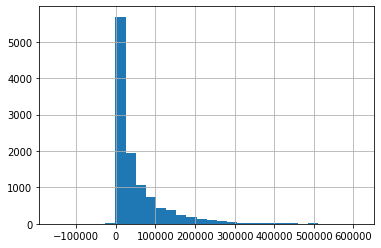

In [14]:
df_t["BILL_AMT1"].hist(bins=30)

In [15]:
#porcentaje de negativos en montos por pagar
for v in ls_bill_amt:
    print(v)
    display((df_t[v]>0).value_counts(1))

BILL_AMT1


True    0.9158
False   0.0842
Name: BILL_AMT1, dtype: float64

BILL_AMT2


True    0.8960
False   0.1040
Name: BILL_AMT2, dtype: float64

BILL_AMT3


True    0.8874
False   0.1126
Name: BILL_AMT3, dtype: float64

BILL_AMT4


True    0.8758
False   0.1242
Name: BILL_AMT4, dtype: float64

BILL_AMT5


True    0.8655
False   0.1345
Name: BILL_AMT5, dtype: float64

BILL_AMT6


True    0.8444
False   0.1556
Name: BILL_AMT6, dtype: float64

**Se supondrá que los valores negativos es saldo a favor**

### Ingeniería de variables

#### total continuas mensuales

In [16]:
df_t["BILL_AMT_mean"] = df_t[ls_bill_amt].mean(axis=1)
df_v["BILL_AMT_mean"] = df_v[ls_bill_amt].mean(axis=1)

df_t["PAY_AMT_mean"] = df_t[ls_pay_amt].mean(axis=1)
df_v["PAY_AMT_mean"] = df_v[ls_pay_amt].mean(axis=1)

#### diferencia entre deuda y pago realizado

In [17]:
for period in range(2,6):
    df_t[f"BILL_PAY_diff{period}"] = df_t[f"BILL_AMT{period}"] - df_t[f"PAY_AMT{period}"]
    df_v[f"BILL_PAY_diff{period}"] = df_v[f"BILL_AMT{period}"] - df_v[f"PAY_AMT{period}"]

In [18]:
df_t

,CUSTOMER_ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT_mean,PAY_AMT_mean,BILL_PAY_diff2,BILL_PAY_diff3,BILL_PAY_diff4,BILL_PAY_diff5
0,2770,130000.0000,2,3,2,32,0,0,0,0,2,119312.0000,116259.0000,103438.0000,49319.0000,91191.0000,82168.0000,20021.0000,40354.0000,20000.0000,43608.0000,103.0000,10000.0000,93614.5000,22813.0000,75905.0000,83438.0000,5711.0000,91088.0000
1,21621,10000.0000,2,2,2,22,-2,-2,-2,-2,-2,0.0000,0.0000,0.0000,-400.0000,0.0000,0.0000,0.0000,0.0000,0.0000,400.0000,0.0000,0.0000,-66.6667,80.0000,0.0000,0.0000,-800.0000,0.0000
2,23530,360000.0000,2,1,1,46,0,-1,0,0,0,58389.0000,42094.0000,10594.0000,31532.0000,46342.0000,56571.0000,20000.0000,10600.0000,30000.0000,20000.0000,15000.0000,10000.0000,40920.3333,17120.0000,31494.0000,-19406.0000,11532.0000,31342.0000
3,27980,80000.0000,2,2,2,60,-2,-2,-2,-2,-2,577.0000,494.0000,438.0000,387.0000,246.0000,939.0000,500.0000,438.0000,387.0000,246.0000,939.0000,350.0000,513.5000,472.0000,56.0000,51.0000,141.0000,-693.0000
4,20014,230000.0000,2,2,2,28,-1,-1,-2,-1,-1,875.0000,375.0000,-250.0000,-125.0000,609.0000,362.0000,1000.0000,0.0000,0.0000,4000.0000,3000.0000,9000.0000,307.6667,3200.0000,375.0000,-250.0000,-4125.0000,-2391.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,27432,150000.0000,2,1,2,27,0,0,0,0,2,138066.0000,140522.0000,138722.0000,130494.0000,147851.0000,145535.0000,5767.0000,6100.0000,30000.0000,19227.0000,0.0000,2606.0000,140198.3333,11586.6000,134422.0000,108722.0000,111267.0000,147851.0000
11246,24219,210000.0000,1,1,2,36,0,0,0,0,0,210463.0000,109132.0000,47182.0000,37067.0000,24511.0000,22634.0000,5187.0000,2043.0000,1552.0000,2013.0000,3002.0000,3003.0000,75164.8333,2322.6000,107089.0000,45630.0000,35054.0000,21509.0000
11247,21973,60000.0000,2,3,1,34,0,0,2,0,0,9928.0000,11261.0000,12853.0000,12352.0000,12703.0000,13338.0000,1500.0000,2090.0000,0.0000,700.0000,1000.0000,1400.0000,12072.5000,1038.0000,9171.0000,12853.0000,11652.0000,11703.0000
11248,5694,360000.0000,2,2,2,34,-2,-2,-2,-2,-2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


#### diferencia entre cada mes para las contiuas

In [19]:
for period in range(1,6):
    df_t[f"BILL_AMT_diff{period}"] = df_t[f"BILL_AMT{period}"] - df_t[f"BILL_AMT{period+1}"]
    df_v[f"BILL_AMT_diff{period}"] = df_v[f"BILL_AMT{period}"] - df_v[f"BILL_AMT{period+1}"]
for period in range(2,6):    
    df_t[f"PAY_AMT_diff{period}"] = df_t[f"PAY_AMT{period}"] - df_t[f"PAY_AMT{period+1}"]
    df_v[f"PAY_AMT_diff{period}"] = df_v[f"PAY_AMT{period}"] - df_v[f"PAY_AMT{period+1}"]

#### promedio de la diferencia entre cada mes

In [20]:
df_t["BILL_AMT_diff_mean"] = df_t[[f"BILL_AMT_diff{x}" for x in range(1,6)]].mean(axis=1)
df_v["BILL_AMT_diff_mean"] = df_v[[f"BILL_AMT_diff{x}" for x in range(1,6)]].mean(axis=1)

df_t["PAY_AMT_diff_mean"] = df_t[[f"PAY_AMT_diff{x}" for x in range(2,6)]].mean(axis=1)
df_v["PAY_AMT_diff_mean"] = df_v[[f"PAY_AMT_diff{x}" for x in range(2,6)]].mean(axis=1)

#### nueva deuda adquirida en el periodo n
nueva_deuda_n = deuda_n - deuna_n-1 + pago_n-1

In [21]:
for period in range(2,6):
    df_t[f"new_debt_{period}"] = df_t[f"BILL_AMT{period}"]-df_t[f"BILL_AMT{period+1}"]+df_t[f"PAY_AMT{period+1}"]
    df_v[f"new_debt_{period}"] = df_v[f"BILL_AMT{period}"]-df_v[f"BILL_AMT{period+1}"]+df_v[f"PAY_AMT{period+1}"]

#### promedio de la deuda adquirida

In [22]:
df_t["new_debt_mean"] = df_t[[f"new_debt_{x}" for x in range(2,6)]].mean(axis=1)
df_v["new_debt_mean"] = df_v[[f"new_debt_{x}" for x in range(2,6)]].mean(axis=1)

In [23]:
df_t

,CUSTOMER_ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT_mean,PAY_AMT_mean,BILL_PAY_diff2,BILL_PAY_diff3,BILL_PAY_diff4,BILL_PAY_diff5,BILL_AMT_diff1,BILL_AMT_diff2,BILL_AMT_diff3,BILL_AMT_diff4,BILL_AMT_diff5,PAY_AMT_diff2,PAY_AMT_diff3,PAY_AMT_diff4,PAY_AMT_diff5,BILL_AMT_diff_mean,PAY_AMT_diff_mean,new_debt_2,new_debt_3,new_debt_4,new_debt_5,new_debt_mean
0,2770,130000.0000,2,3,2,32,0,0,0,0,2,119312.0000,116259.0000,103438.0000,49319.0000,91191.0000,82168.0000,20021.0000,40354.0000,20000.0000,43608.0000,103.0000,10000.0000,93614.5000,22813.0000,75905.0000,83438.0000,5711.0000,91088.0000,3053.0000,12821.0000,54119.0000,-41872.0000,9023.0000,20354.0000,-23608.0000,43505.0000,-9897.0000,7428.8000,7588.5000,32821.0000,97727.0000,-41769.0000,19023.0000,26950.5000
1,21621,10000.0000,2,2,2,22,-2,-2,-2,-2,-2,0.0000,0.0000,0.0000,-400.0000,0.0000,0.0000,0.0000,0.0000,0.0000,400.0000,0.0000,0.0000,-66.6667,80.0000,0.0000,0.0000,-800.0000,0.0000,0.0000,0.0000,400.0000,-400.0000,0.0000,0.0000,-400.0000,400.0000,0.0000,0.0000,0.0000,0.0000,800.0000,-400.0000,0.0000,100.0000
2,23530,360000.0000,2,1,1,46,0,-1,0,0,0,58389.0000,42094.0000,10594.0000,31532.0000,46342.0000,56571.0000,20000.0000,10600.0000,30000.0000,20000.0000,15000.0000,10000.0000,40920.3333,17120.0000,31494.0000,-19406.0000,11532.0000,31342.0000,16295.0000,31500.0000,-20938.0000,-14810.0000,-10229.0000,-19400.0000,10000.0000,5000.0000,5000.0000,363.6000,150.0000,61500.0000,-938.0000,190.0000,-229.0000,15130.7500
3,27980,80000.0000,2,2,2,60,-2,-2,-2,-2,-2,577.0000,494.0000,438.0000,387.0000,246.0000,939.0000,500.0000,438.0000,387.0000,246.0000,939.0000,350.0000,513.5000,472.0000,56.0000,51.0000,141.0000,-693.0000,83.0000,56.0000,51.0000,141.0000,-693.0000,51.0000,141.0000,-693.0000,589.0000,-72.4000,22.0000,443.0000,297.0000,1080.0000,-343.0000,369.2500
4,20014,230000.0000,2,2,2,28,-1,-1,-2,-1,-1,875.0000,375.0000,-250.0000,-125.0000,609.0000,362.0000,1000.0000,0.0000,0.0000,4000.0000,3000.0000,9000.0000,307.6667,3200.0000,375.0000,-250.0000,-4125.0000,-2391.0000,500.0000,625.0000,-125.0000,-734.0000,247.0000,0.0000,-4000.0000,1000.0000,-6000.0000,102.6000,-2250.0000,625.0000,3875.0000,2266.0000,9247.0000,4003.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,27432,150000.0000,2,1,2,27,0,0,0,0,2,138066.0000,140522.0000,138722.0000,130494.0000,147851.0000,145535.0000,5767.0000,6100.0000,30000.0000,19227.0000,0.0000,2606.0000,140198.3333,11586.6000,134422.0000,108722.0000,111267.0000,147851.0000,-2456.0000,1800.0000,8228.0000,-17357.0000,2316.0000,-23900.0000,10773.0000,19227.0000,-2606.0000,-1493.8000,873.5000,31800.0000,27455.0000,-17357.0000,4922.0000,11705.0000
11246,24219,210000.0000,1,1,2,36,0,0,0,0,0,210463.0000,109132.0000,47182.0000,37067.0000,24511.0000,22634.0000,5187.0000,2043.0000,1552.0000,2013.0000,3002.0000,3003.0000,75164.8333,2322.6000,107089.0000,45630.0000,35054.0000,21509.0000,101331.0000,61950.0000,10115.0000,12556.0000,1877.0000,491.0000,-461.0000,-989.0000,-1.0000,37565.8000,-240.0000,63502.0000,12128.0000,15558.0000,4880.0000,24017.0000
11247,21973,60000.0000,2,3,1,34,0,0,2,0,0,9928.0000,11261.0000,12853.0000,12352.0000,12703.0000,13338.0000,1500.0000,2090.0000,0.0000,700.0000,1000.0000,1400.0000,12072.5000,1038.0000,9171.0000,12853.0000,11652.0000,11703.0000,-1333.0000,-1592.0000,501.0000,-351.0000,-635.0000,2090.0000,-700.0000,-300.0000,-400.0000,-682.0000,172.5000,-1592.0000,1201.0000,649.0000,765.0000,255.7500
11248,5694,360000.0000,2,2,2,34,-2,-2,-2,-2,-2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,

In [24]:
set(df_t.columns)-set(df_v.columns)

{'PAY_AMT1'}

### Transformando variables categóricas

In [25]:
for v in ls_disc:
    df_t, df_v, embedding = make_embedding(df_t, df_v, v, target)

Creating embedding for SEX

Epoch 1/25
2/2 [==============================] - 9s 10ms/step - loss: 32.8157 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 2/25
2/2 [==============================] - 0s 13ms/step - loss: -72.8745 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 3/25
2/2 [==============================] - 0s 12ms/step - loss: -179.2453 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 4/25
2/2 [==============================] - 0s 15ms/step - loss: -290.1782 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 5/25
2/2 [==============================] - 0s 12ms/step - loss: -407.9199 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 6/25
2/2 [==============================] - 0s 11ms/step - loss: -524.4916 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 7/25
2/2 [==============================] - 0s 12ms/step - loss: -647.2793 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 8/25
2/2 [==============================] - 0s 14ms/step - loss: -788.8578 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 9/25
2/2 [===============

2/2 [==============================] - 0s 14ms/step - loss: -2069.1166 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 20/25
2/2 [==============================] - 0s 11ms/step - loss: -2268.2703 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 21/25
2/2 [==============================] - 0s 13ms/step - loss: -2430.7853 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 22/25
2/2 [==============================] - 0s 12ms/step - loss: -2565.7418 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 23/25
2/2 [==============================] - 0s 12ms/step - loss: -2821.1527 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 24/25
2/2 [==============================] - 0s 14ms/step - loss: -2994.0836 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 25/25
2/2 [==============================] - 0s 14ms/step - loss: -3263.1300 - accuracy: 5.9259e-05 - roc: 0.5000
Creating embedding for AGE

Epoch 1/25
2/2 [==============================] - 1s 10ms/step - loss: 56.0900 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 2/25
2/2 [============

2/2 [==============================] - 0s 14ms/step - loss: -1678.7273 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 13/25
2/2 [==============================] - 0s 11ms/step - loss: -1836.3516 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 14/25
2/2 [==============================] - 0s 14ms/step - loss: -2017.3790 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 15/25
2/2 [==============================] - 0s 12ms/step - loss: -2202.5181 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 16/25
2/2 [==============================] - 0s 11ms/step - loss: -2337.4684 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 17/25
2/2 [==============================] - 0s 15ms/step - loss: -2561.5140 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 18/25
2/2 [==============================] - 0s 16ms/step - loss: -2734.5374 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 19/25
2/2 [==============================] - 0s 16ms/step - loss: -2954.0424 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 20/25
2/2 [==============================] - 0

2/2 [==============================] - 0s 14ms/step - loss: -294.3474 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 6/25
2/2 [==============================] - 0s 12ms/step - loss: -372.8611 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 7/25
2/2 [==============================] - 0s 11ms/step - loss: -446.8812 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 8/25
2/2 [==============================] - 0s 16ms/step - loss: -535.1311 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 9/25
2/2 [==============================] - 0s 14ms/step - loss: -617.2361 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 10/25
2/2 [==============================] - 0s 16ms/step - loss: -709.8083 - accuracy: 1.1481e-04 - roc: 0.5000
Epoch 11/25
2/2 [==============================] - 0s 13ms/step - loss: -812.6222 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 12/25
2/2 [==============================] - 0s 11ms/step - loss: -890.6955 - accuracy: 5.9259e-05 - roc: 0.5000
Epoch 13/25
2/2 [==============================] - 0s 12ms/step 

## Modelado

### Separación de sets

In [26]:
X = df_t.drop(columns='PAY_AMT1')
y = df_t[target]

### Escalado

In [27]:
mm = MinMaxScaler()
Xs = pd.DataFrame(mm.fit_transform(X), columns=X.columns, index=X.index)
df_vs = pd.DataFrame(mm.transform(df_v), columns=df_v.columns, index=df_v.index)
Xs

,CUSTOMER_ID,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT_mean,PAY_AMT_mean,BILL_PAY_diff2,BILL_PAY_diff3,BILL_PAY_diff4,BILL_PAY_diff5,BILL_AMT_diff1,BILL_AMT_diff2,BILL_AMT_diff3,BILL_AMT_diff4,BILL_AMT_diff5,PAY_AMT_diff2,...,SEX_embedding_2,EDUCATION_embedding_0,EDUCATION_embedding_1,EDUCATION_embedding_2,MARRIAGE_embedding_0,MARRIAGE_embedding_1,MARRIAGE_embedding_2,AGE_embedding_0,AGE_embedding_1,AGE_embedding_2,PAY_2_embedding_0,PAY_2_embedding_1,PAY_2_embedding_2,PAY_3_embedding_0,PAY_3_embedding_1,PAY_3_embedding_2,PAY_4_embedding_0,PAY_4_embedding_1,PAY_4_embedding_2,PAY_5_embedding_0,PAY_5_embedding_1,PAY_5_embedding_2,PAY_6_embedding_0,PAY_6_embedding_1,PAY_6_embedding_2
0,0.0923,0.1519,0.3568,0.2286,0.3541,0.2746,0.1724,0.4942,0.0332,0.0225,0.0702,0.0002,0.0190,0.2308,0.0395,0.6325,0.6592,0.5426,0.3715,0.4621,0.4740,0.6010,0.4841,0.4371,0.5130,...,0.0000,0.0000,1.0000,0.0000,0.5215,0.3509,0.0000,0.4817,0.7091,0.5514,0.0000,0.7488,0.7400,0.8861,0.1238,0.0000,0.5189,0.8165,0.9520,0.0962,1.0000,0.2968,1.0000,0.7680,0.6170
1,0.8594,0.1392,0.2219,0.1060,0.2363,0.2344,0.0900,0.4182,0.0013,0.0022,0.0024,0.0011,0.0133,0.1125,0.0043,0.5979,0.6109,0.5506,0.3070,0.4576,0.4603,0.5333,0.5284,0.4267,0.4858,...,0.0000,0.1970,0.5704,0.2745,0.5215,0.3509,0.0000,0.4817,0.7091,0.5514,0.0000,0.7488,0.7400,0.8861,0.1238,0.0000,0.5189,0.8165,0.9520,0.0962,1.0000,0.2968,1.0000,0.7680,0.6170
2,0.6555,0.1519,0.3734,0.2467,0.3454,0.2887,0.1395,0.4692,0.0038,0.0056,0.0081,0.0000,0.0114,0.2261,0.0071,0.6611,0.6652,0.5828,0.3459,0.4599,0.4963,0.5790,0.5280,0.4270,0.4858,...,0.0000,1.0000,0.4113,0.3483,0.5215,0.3509,0.0000,0.4817,0.7091,0.5514,0.0000,0.7488,0.7400,0.8861,0.1238,0.0000,0.5189,0.8165,0.9520,0.0962,1.0000,0.2968,1.0000,0.7680,0.6170
3,0.3160,0.1899,0.2411,0.1154,0.2273,0.2202,0.0764,0.4030,0.0009,0.0003,0.0008,0.0000,0.0019,0.1073,0.0010,0.6025,0.6074,0.5423,0.2968,0.4658,0.4753,0.5390,0.5293,0.4279,0.4873,...,0.0000,0.1970,0.5704,0.2745,0.0277,0.0000,0.1324,0.4817,0.7091,0.5514,0.0000,0.7488,0.7400,0.8861,0.1238,0.0000,0.5189,0.8165,0.9520,0.0962,1.0000,0.2968,1.0000,0.7680,0.6170
4,0.8829,0.1139,0.3291,0.2062,0.3478,0.3355,0.1845,0.5128,0.0039,0.0044,0.0127,0.0000,0.0146,0.2387,0.0084,0.6423,0.6672,0.6106,0.3810,0.4587,0.4597,0.5348,0.5253,0.4304,0.4874,...,0.0000,1.0000,0.4113,0.3483,0.0277,0.0000,0.1324,0.4817,0.7091,0.5514,0.0000,0.7488,0.7400,0.8861,0.1238,0.0000,0.5189,0.8165,0.9520,0.0962,1.0000,0.2968,1.0000,0.7680,0.6170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,0.2400,0.2152,0.2047,0.0887,0.2169,0.2159,0.0721,0.4008,0.0000,0.0000,0.0000,0.0000,0.0000,0.0901,0.0000,0.5908,0.6022,0.5399,0.2934,0.4586,0.4605,0.5338,0.5296,0.4255,0.4864,...,1.0000,1.0000,0.4113,0.3483,0.5215,0.3509,0.0000,0.9270,0.5117,0.8890,0.4530,0.4182,0.9688,0.6429,0.8311,0.1234,0.7212,0.4165,0.1478,1.0000,0.9322,0.1160,0.6487,0.5200,0.8763
11246,0.5315,0.0380,0.2047,0.0887,0.2169,0.2159,0.0721,0.4008,0.0000,0.0000,0.0000,0.0000,0.0000,0.0901,0.0000,0.5908,0.6022,0.5399,0.2934,0.4586,0.4605,0.5338,0.5296,0.4255,0.4864,...,0.0000,0.0000,1.0000,0.0000,0.0277,0.0000,0.1324,0.7391,0.6137,0.7160,0.4530,0.4182,0.9688,0.6429,0.8311,0.1234,0.7212,0.4165,0.1478,1.0000,0.9322,0.1160,0.6487,0.5200,0.8763
11247,0.2693,0.0253,0.2047,0.0887,0.2169,0.2158,0.0721,0.4007,0.0000,0.0000,0.0000,0.0000,0.0000,0.0901,0.0000,0.5908,0.6022,0.5399,0.2934,0.4586,0.4605,0.5338,0.5296,0.4255,0.4864,...,1.0000,0.0000,1.0000,0.0000,0.0277,0.0000,0.1324,0.7391,0.6137,0.7160,0.4530,0.4182,0.9688,0.6429,0.8311,0.1234,0.7212,0.4165,0.1478,1.0000,0.9322,0.1160,0.6487,0.5200,0.8763
11248,0.0707,0.4304,0.2047,0.0887,0.2169,0.2159,0.0721,0.4008,0.0000,0.0000,0.0000,0.0000,0.0000,0.0901,0.0000,0.5908,0.6022,0.5399,0.2934,0.4586,0.4605,0.5338,0

### Autoencoder

In [28]:
autoencoder, encoder = make_autoencoder(X_train=Xs, encoding_dim=np.round(np.sqrt(Xs.shape[1]), 0), batch_size=1500, epochs=50)

Epoch 1/50
8/8 [==============================] - 1s 3ms/step - loss: 0.2552 - rms: 0.5051 - mae: 0.4082
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.2396 - rms: 0.4895 - mae: 0.3947
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.2243 - rms: 0.4736 - mae: 0.3830
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.2033 - rms: 0.4508 - mae: 0.3612
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.1740 - rms: 0.4170 - mae: 0.3290
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.1417 - rms: 0.3764 - mae: 0.2900
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 0.1113 - rms: 0.3336 - mae: 0.2489
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0860 - rms: 0.2932 - mae: 0.2125
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0676 - rms: 0.2599 - mae: 0.1816
Epoch 10/50
8/8 [==============================] - 0s 4

In [29]:
Xe = pd.DataFrame(data=encoder.predict(Xs), index=Xs.index)
df_ve = pd.DataFrame(data=encoder.predict(df_vs), index=df_vs.index)

### Pipeline

In [30]:
pipe = Pipeline([("vt", VarianceThreshold(threshold=0.0001)), ("mm", StandardScaler())])

### Modelos

In [31]:
names = ["Linear Regression","KNN","Decision Tree","Random Forest","Lasso Regression",
        "Ridge Regression","Elastic Net","AdaBoost","Neural Network"]
classifiers = [
    LinearRegression(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    Lasso(),
    Ridge(),
    ElasticNet(),
    AdaBoostRegressor(),
    MLPRegressor()
]

In [32]:
classifiers_dict = {name:{"modelo":classifier} for name, classifier in zip(names,classifiers)}

### Cross Valdation

In [33]:
for modelo in classifiers_dict:
    print(modelo)
    classifiers_dict[modelo]["R2"] = regression_metrics(Xs, y, pipe, classifiers_dict[modelo]["modelo"])
    print("\n")

Linear Regression
R2 media: -141,262,285,657,358,072,488,656,896.00, desviación estándar: 244,673,455,951,852,463,653,388,288.00


KNN
R2 media: 0.38, desviación estándar: 0.16


Decision Tree
R2 media: 0.37, desviación estándar: 0.17


Random Forest
R2 media: 0.63, desviación estándar: 0.16


Lasso Regression
R2 media: 0.34, desviación estándar: 0.15


Ridge Regression
R2 media: 0.34, desviación estándar: 0.15


Elastic Net
R2 media: 0.36, desviación estándar: 0.09


AdaBoost
R2 media: -0.89, desviación estándar: 1.02


Neural Network
R2 media: 0.36, desviación estándar: 0.15




### Hyperparametrización

#### Random Forest

In [34]:
model = RandomForestRegressor()
param_grid = {"model__n_estimators" : [100,150],
              "model__criterion":["mse", "mae"],
              "model__bootstrap":[True,False],
              "model__oob_score":[True,False]}


In [35]:
bm = hyperparam_logistic(Xs, y, pipe, model, param_grid)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


/home/paramont/work/envs/diplomado/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



R2: 0.63


#### KNN

In [36]:
model = KNeighborsRegressor()
param_grid = {"model__n_neighbors" : range(5,91)}

In [37]:
knn = hyperparam_logistic(Xs, y, pipe, model, param_grid)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
R2: 0.37


#### Elastic Net

In [38]:
model = ElasticNet(max_iter=10000)
param_grid = {
              "model__alpha":np.arange(0.1,10,.5)
             }

In [39]:
en = hyperparam_logistic(Xs, y, pipe, model, param_grid)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
R2: 0.36


### Resultados

In [40]:
y["pred"] = bm.predict(Xs)

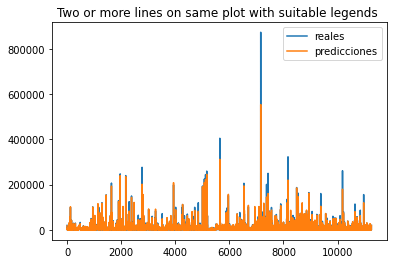

In [41]:
plt.plot(y.index, y["PAY_AMT1"], label = "reales")
plt.plot(y.index, y["pred"], label = "predicciones")
plt.title('Two or more lines on same plot with suitable legends ')
plt.legend()
plt.show()

### Transformando el dataset de validación

In [42]:
resultados = pd.DataFrame()
resultados["CUSTOMER_ID"] = df_v["CUSTOMER_ID"]
resultados["y_hat"] = bm.predict(df_vs.fillna(0))

In [43]:
resultados.to_csv("HernandezGonzalezRicardoParamont_PAYAMT12.csv",index=False)